In [ ]:
import numpy as np
import pandas as pd
from time import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import re

import tensorflow as tf
from tensorflow import keras
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.model_selection import TimeSeriesSplit

from pandas.plotting import register_matplotlib_converters, autocorrelation_plot
register_matplotlib_converters()
sns.mpl.rc("figure", figsize=(10, 5))
sns.mpl.rc("font", size=14)
from pandas.tseries.offsets import DateOffset

import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/task2.xlsx'
data = pd.read_excel(file_path, header=0)
data.head()

,period,price
0,SEP 2022\nTTFU2,272.605
1,OCT 2022\nTTFV2,292.430
2,NOV 2022\nTTFX2,297.410
3,DEC 2022\nTTFZ2,297.810
4,JAN 2023\nTTFF3,294.400


In [ ]:
data['period'] = data.period.apply(lambda x: x[:8])
data.index = pd.to_datetime(data.period, format='%b %Y')
data.drop('period', inplace=True, axis=1)
data.head()

,price
period,
2022-09-01,272.605
2022-10-01,292.430
2022-11-01,297.410
2022-12-01,297.810
2023-01-01,294.400


In [ ]:
data.isna().sum()

price    0
dtype: int64

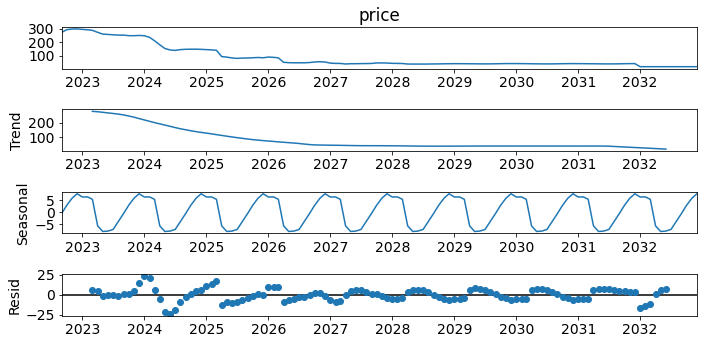

In [ ]:
result = seasonal_decompose(data['price'], model = 'additive')
resultmult = result.plot()

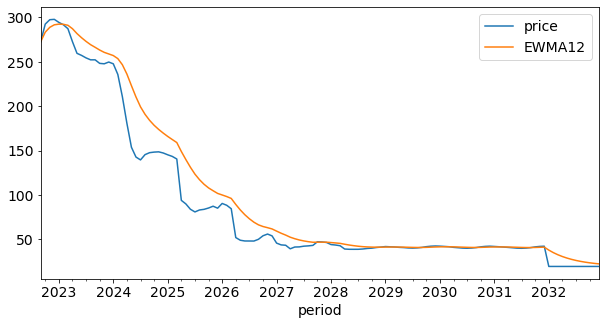

In [ ]:
# EWMA
# Exponentially-weighted moving average

data['EWMA12'] = data.price.ewm(span=12).mean()
data[['price','EWMA12']].plot()

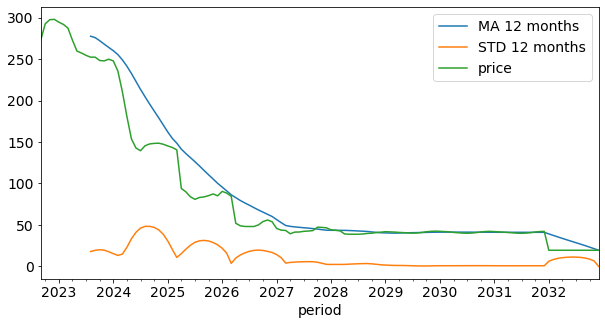

In [ ]:
data['price'].rolling(12).mean().plot(label='MA 12 months')
data['price'].rolling(12).std().plot(label='STD 12 months')
data['price'].plot()
plt.legend()

In [ ]:
# to check for mean/std are no changing too much over time - data is stationary - we run a test for ADF
from statsmodels.tsa.stattools import adfuller

def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adf_check(data['price']) 

Augmented Dickey-Fuller Test:
ADF Test Statistic : -4.897628984573932
p-value : 3.524686333955374e-05
#Lags Used : 12
Number of Observations Used : 111
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


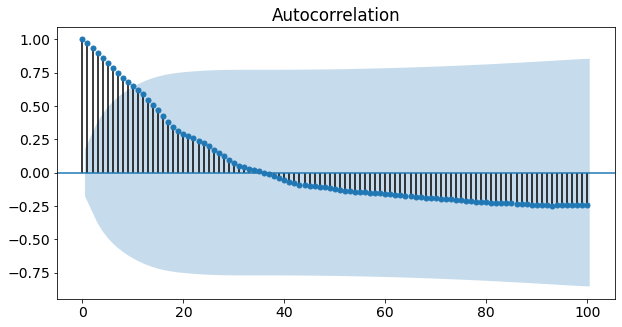

In [ ]:
acf_plot = plot_acf(data['price'], lags=100) 

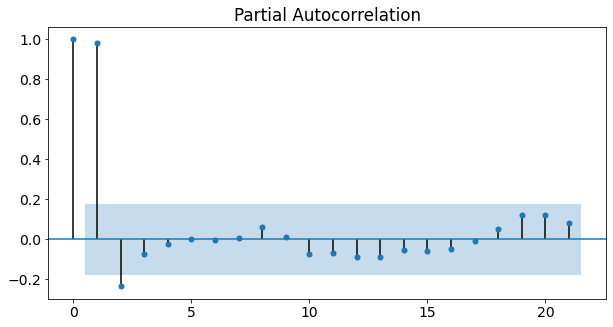

In [ ]:
acf_plot = plot_pacf(data['price'])

In [ ]:
data.head(1)

,price,EWMA12
period,,
2022-09-01,272.605,272.605


In [ ]:
data.tail(1)

,price,EWMA12
period,,
2032-12-01,19.505,22.435679


In [ ]:
data.drop('EWMA12', inplace=True, axis=1)

In [ ]:
df=data.copy()

In [ ]:
# data = df.copy()

In [ ]:
data.head()

,price
period,
2022-09-01,272.605
2022-10-01,292.430
2022-11-01,297.410
2022-12-01,297.810
2023-01-01,294.400


In [ ]:
# data=df.copy()
# data.head(2)

In [ ]:
data.columns = ["y"]
for i in range(1, 25):
  data["lag_{}".format(i)] = data.y.shift(i)

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
y = data.dropna().y
X = data.dropna().drop(["y"], axis=1)
# reserve 30% of data for testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
tscv = TimeSeriesSplit(n_splits=5)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge = RidgeCV(alphas=(0.1, 0.8, 1.0, 5.0),scoring='neg_mean_absolute_error',cv=tscv)

ridge.fit(X_train_scaled, y_train)

ridge.alpha_

0.8

In [ ]:
test_predictions = ridge.predict(X_test_scaled)
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [ ]:
MAE

2.930160004848787

In [ ]:
RMSE

5.099869821935052

In [ ]:
# Training Set Performance
train_predictions = ridge.predict(X_train_scaled)
MAE = mean_absolute_error(y_train,train_predictions)
MAE

2.626310105545146

In [ ]:
ridge.coef_

array([16.23449624,  3.61373341,  3.46842059,  3.22456495,  1.2765486 ,
        0.97434276,  0.06874306, -1.53512641,  1.70836912,  2.97341266,
        8.80912131, 10.54785966, -3.27181169, -3.64933482, -5.87824704,
       -3.70910613, -2.30582894, -1.09889189, -0.54350171,  0.44238337,
        1.22363621, -1.66854123,  1.33335633, -1.62349204])

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result


def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """

    with plt.style.context("seaborn-white"):
        plt.figure(figsize=(10, 4))
        for alpha in alphas:
            for beta in betas:
                plt.plot(
                    double_exponential_smoothing(series, alpha, beta),
                    label="Alpha {}, beta {}".format(alpha, beta),
                )
        plt.plot(series.values, label="Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

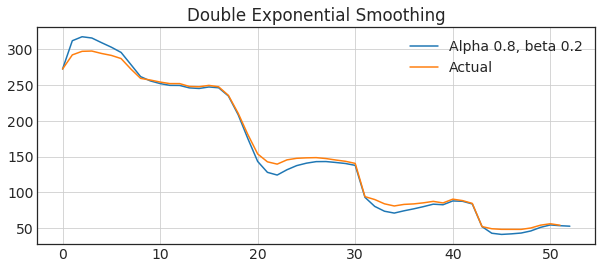

In [ ]:
plotDoubleExponentialSmoothing(data.iloc[:52]['y'], alphas=[0.8], betas=[0.2])
# train_data = data.iloc[:36]['y']
# test_data = data.iloc[36:52]['y']
# predict_start_date = data.index[36]
# predict_end_date = data.index[51]